In [1]:
# Imports
import pathlib

import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from rsc.train.dataset import RoadSurfaceDataset
from rsc.train.plmcnn import PLMaskCNN
from rsc.train.preprocess import PreProcess

# Get PyTorch device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Inputs
dataset_val_csv = pathlib.Path('/data/road_surface_classifier/dataset_multiclass/dataset_val.csv')
assert dataset_val_csv.is_file()
model_path = pathlib.Path('/data/road_surface_classifier/results/20230501_150852Z/model-0-epoch=17-val_loss=0.38361.ckpt')
assert model_path.is_file()
chip_size = 128

In [2]:
# Create dataloader for validation set
val_ds = RoadSurfaceDataset(dataset_val_csv, transform=PreProcess(), chip_size=chip_size)
val_dl = DataLoader(val_ds,
                    num_workers=0,
                    batch_size=32,
                    shuffle=False)

In [3]:
# Load model from file
model = PLMaskCNN.load_from_checkpoint(model_path)
model.eval()

PLMaskCNN(
  (transform): DataAugmentation(
    (transform_flip): Sequential(
      (0): RandomHorizontalFlip(p=0.5, p_batch=1.0, same_on_batch=False)
      (1): RandomVerticalFlip(p=0.5, p_batch=1.0, same_on_batch=False)
    )
    (transform_offset): Sequential(
      (0): RandomAffine(degrees=(-15, 15), translate=(0.0625, 0.0625), scale=None, shear=None, p=0.5, p_batch=1.0, same_on_batch=False, resample=bilinear, padding_mode=zeros, align_corners=False)
    )
    (transform_color): Sequential(
      (0): RandomPlasmaBrightness(roughness=(0.1, 0.5), intensity=(0.1, 0.3), p=0.5, p_batch=1.0, same_on_batch=False)
      (1): ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=1.0, p_batch=1.0, same_on_batch=False)
    )
    (transform_nir): Sequential(
      (0): ColorJitterNoHueSat(brightness=0.1, contrast=0.1, saturation=0.0, hue=0.0, p=1.0, p_batch=1.0, same_on_batch=False)
    )
  )
  (loss): MCNNLoss(
    (hxe_loss): RSCHXELoss()
    (o_loss): BCEWithLogitsLoss()
  

In [230]:
true_all, logits_all = [], []

# Generate a tensor of true classes and predicted class by the model
for dl_iter in tqdm(iter(val_dl)):
    x, _ = dl_iter

    # Extract just the image + location mask for inference
    x = x[:, 0:5, :, :].to(device)

    # Run model
    model_out = model(x)

    # Persist true class
    _, true = dl_iter
    true_all.append(true[:, :-1].cpu().numpy())
    # true_all[-1] = np.array([true_all[-1][:, :4].sum(axis=1), true_all[-1][:, -4:].sum(axis=1)]).T
    
    # Get model prediction and confidence
    _, logits = model_out
    logits = logits[:, :-1].detach().cpu().numpy()
    logits_all.append(logits)
    # logits_all[-1] = np.array([logits_all[-1][:, :4].mean(axis=1), logits_all[-1][:, -4:].mean(axis=1)]).T

# Combine all batches
true_all = np.concatenate(true_all)
logits_all = np.concatenate(logits_all, axis=0)


  0%|          | 0/229 [00:00<?, ?it/s]

Total Error:  0.7211055243406836


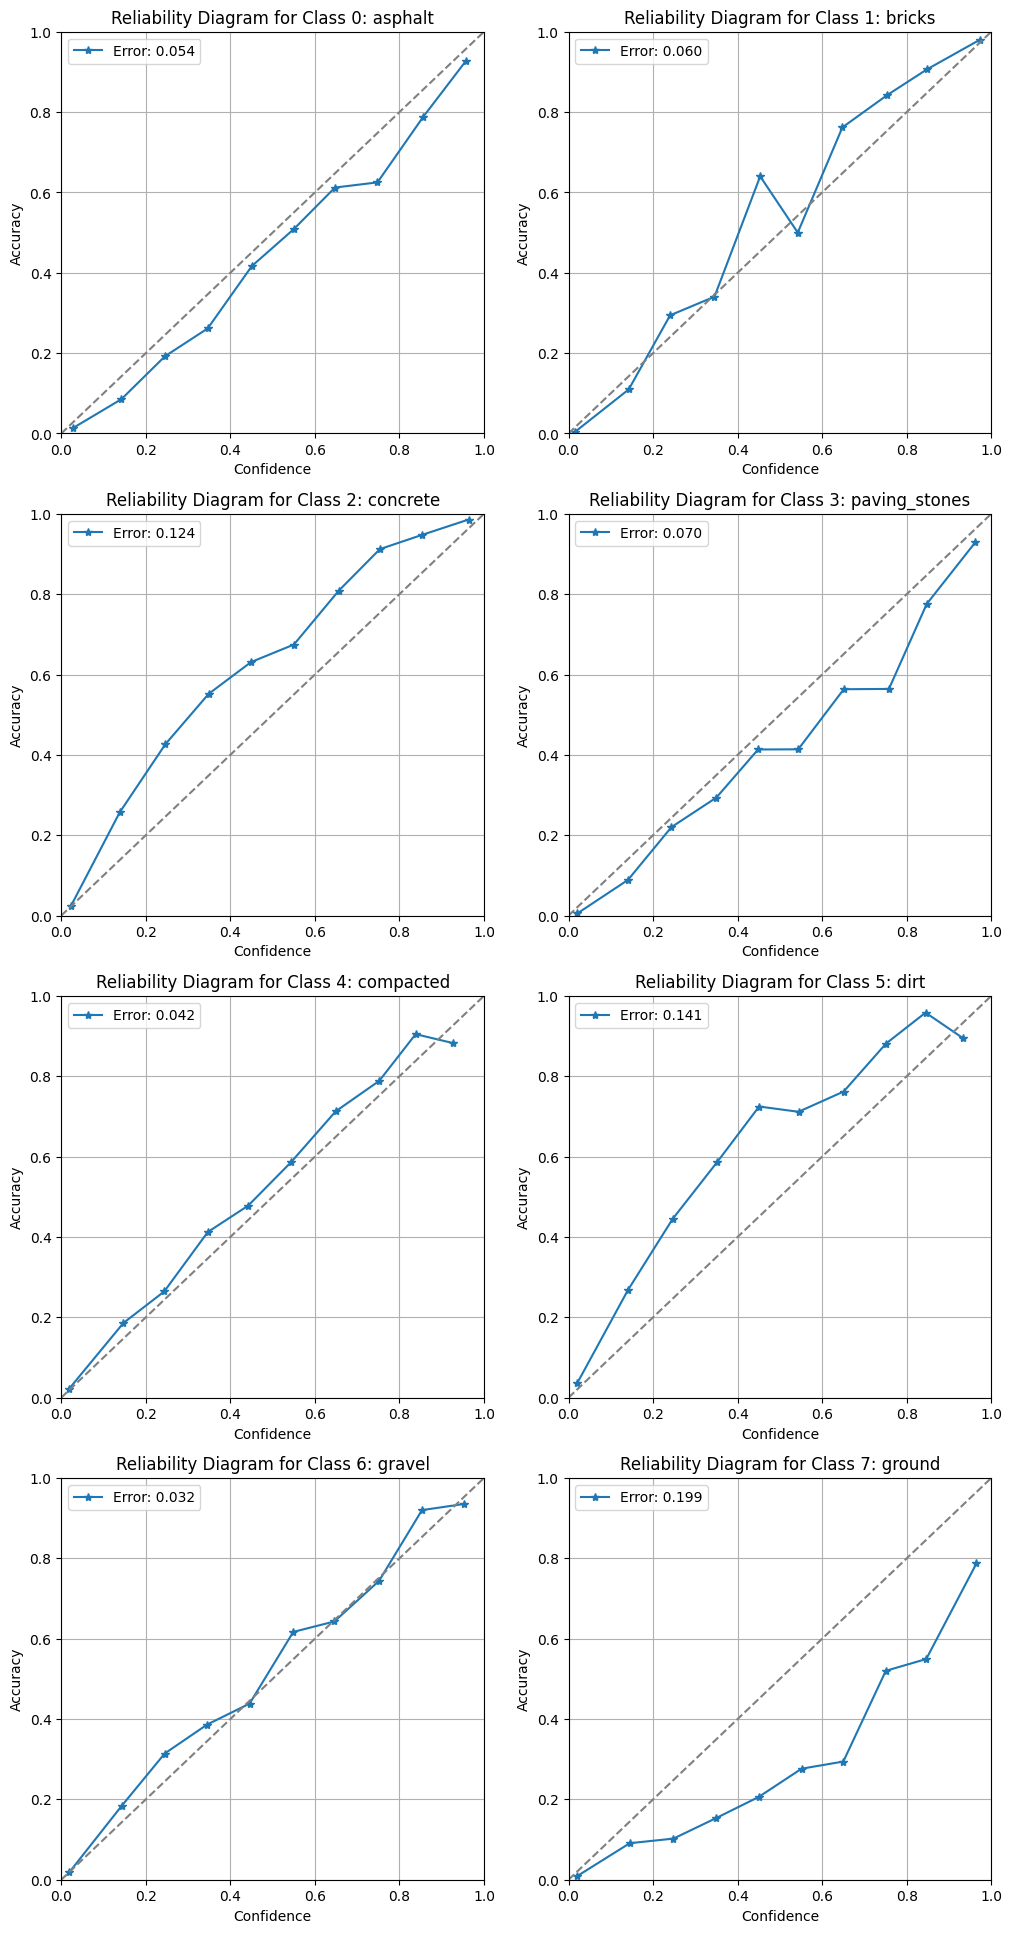

In [269]:
labels = ['asphalt', 'bricks', 'concrete', 'paving_stones', 'compacted', 'dirt', 'gravel', 'ground']
# labels = ['paved', 'unpaved']

true_lbl_all = np.argmax(true_all, axis=1)

# Generate calibration plot for each class
def calibration_plot(ax, true, cl_idx, pred_conf):
    bin_edges = np.linspace(0, 1, 11)
    assert pred_conf.ndim == 2

    true = np.repeat(true, pred_conf.shape[1])
    pred = np.stack([np.arange(pred_conf.shape[1])] * pred_conf.shape[0]).flatten()
    pred_conf = pred_conf.flatten()

    idxs = np.searchsorted(bin_edges, pred_conf, side='left')

    acc = np.empty(bin_edges.shape)
    bin_loc = np.empty(bin_edges.shape)
    acc.fill(np.nan)
    for bin_idx, bin_val in enumerate(bin_edges):
        idx = np.nonzero(idxs == bin_idx)[0]
        idx = idx[np.nonzero(pred[idx] == cl_idx)[0]]
        if not len(idx):
            continue
        acc[bin_idx] = (true[idx] == pred[idx]).sum() / len(idx)
        bin_loc[bin_idx] = pred_conf[idx].mean()

    error = np.abs(bin_loc[1:] - acc[1:]).mean()
    
    ax.plot(bin_loc, acc, '-*', label='Error: %.3f' % error)
    ax.plot(bin_edges, bin_edges , '--', color='grey')
    ax.grid(True)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Confidence')
    ax.set_ylabel('Accuracy')
    ax.legend()

    return error

T = 1
pred_sm = torch.softmax(torch.Tensor(logits_all / T), dim=1)
pred_sm = pred_sm.cpu().numpy()
fig, ax = plt.subplots(4, 2, figsize=(12, 24))
errors = []
for cl_idx, _ax in enumerate(ax.flatten()):
    err = calibration_plot(_ax, true_lbl_all, cl_idx, pred_sm)
    errors.append(err)
    _ax.set_title('Reliability Diagram for Class %d: %s' % (cl_idx, labels[cl_idx]))

print('Total Error: ', sum(errors))

Parameter containing:
tensor([0.9453], device='cuda:0', requires_grad=True)


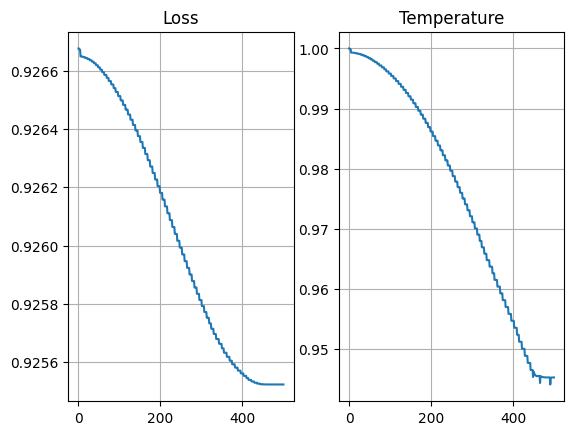

In [265]:
# https://towardsdatascience.com/neural-network-calibration-using-pytorch-c44b7221a61
import torch.nn as nn
import torch.optim as optim

def T_scaling(logits, temp):
  return torch.div(logits, temp)

temp = nn.Parameter(torch.ones(1).to(device))
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS([temp], lr=1e-4, max_iter=10000, line_search_fn='strong_wolfe')

# Create tensors
logits_t = torch.Tensor(logits_all).to(device)
true_t = torch.Tensor(true_all).to(device)

temps, losses = [], []
def _eval():
  loss = criterion(T_scaling(logits_t, temp), true_t)
  temps.append(temp.item())
  losses.append(loss.detach().cpu().numpy())
  loss.backward()
  return loss

optimizer.step(_eval)

print(temp)

fig, ax = plt.subplots(1, 2)
ax[0].plot(losses)
ax[0].grid()
ax[0].set_title('Loss')
ax[1].plot(temps)
ax[1].grid()
ax[1].set_title('Temperature')
plt.show()

Total Error:  0.7211055243406836
Total Error:  0.7360824410105392


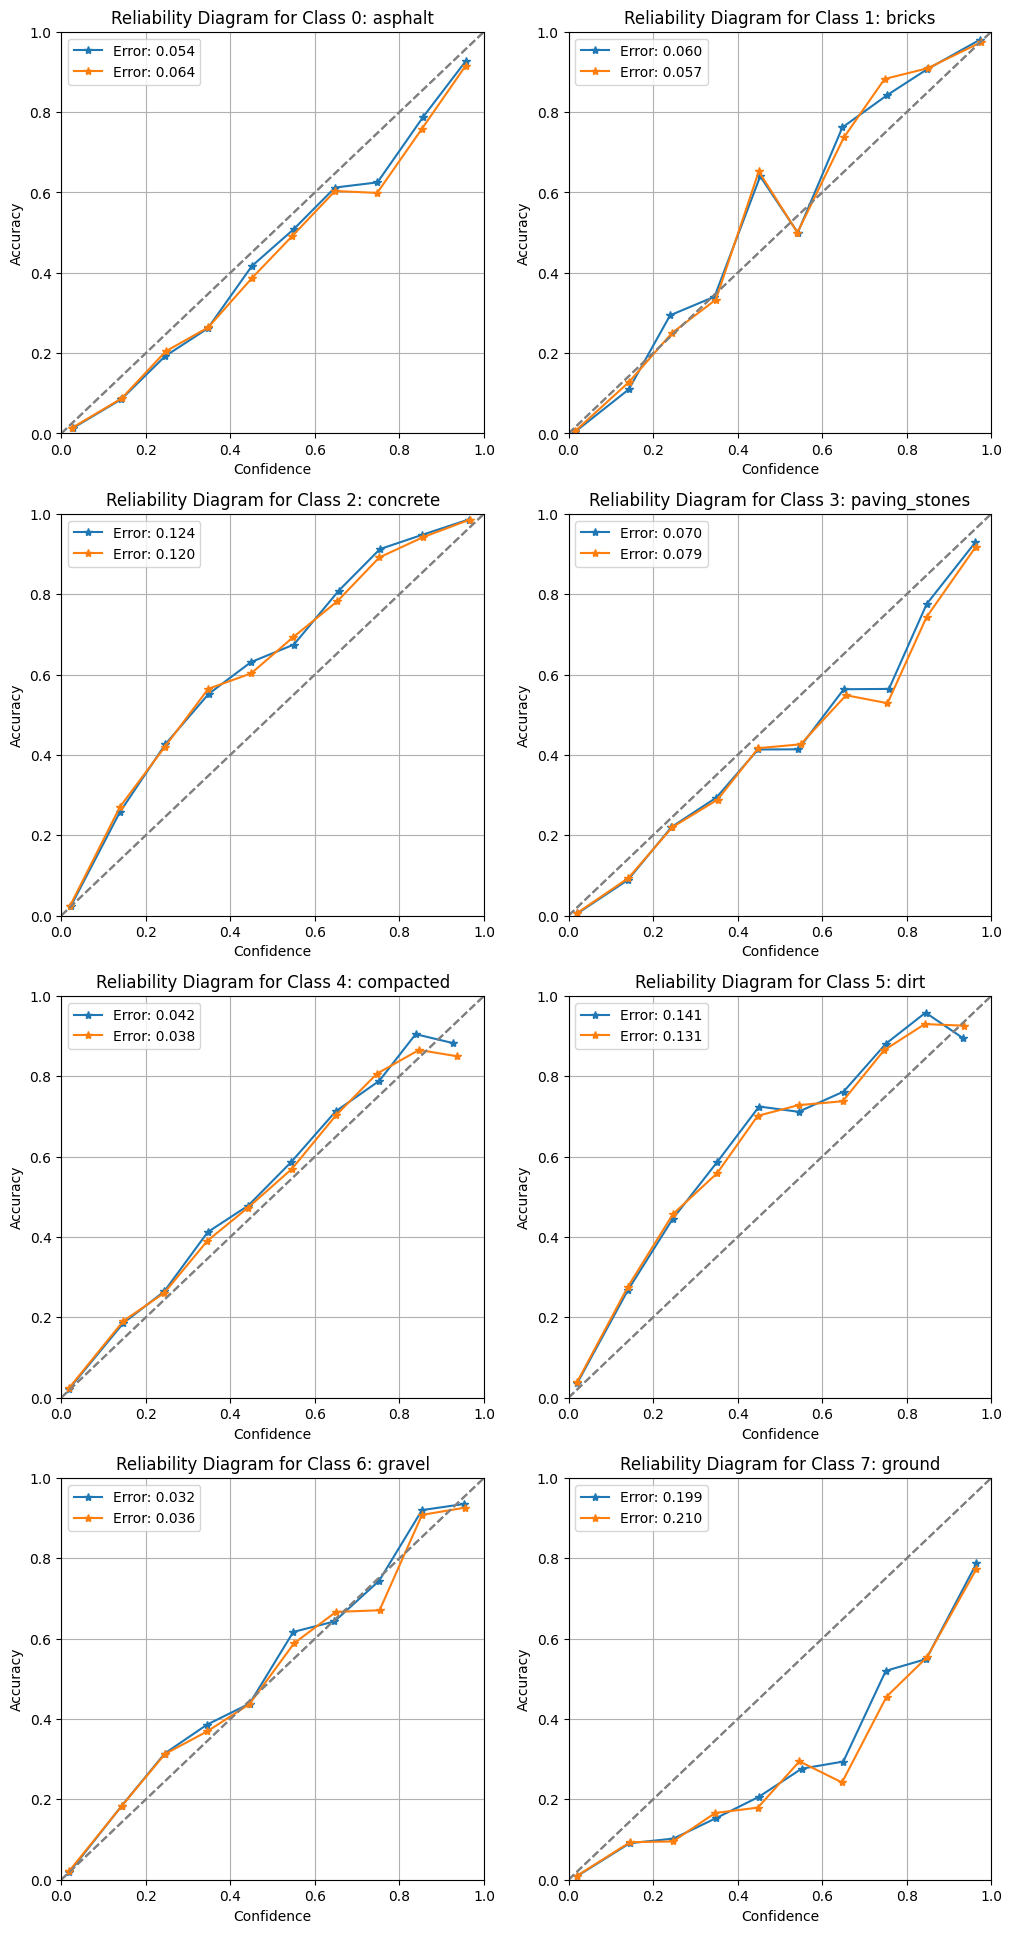

In [288]:
T = temp.item()

fig, ax = plt.subplots(4, 2, figsize=(12, 24))

pred_sm = torch.softmax(torch.Tensor(logits_all / 1), dim=1)
pred_sm = pred_sm.cpu().numpy()

errors = []
for cl_idx, _ax in enumerate(ax.flatten()):
    err = calibration_plot(_ax, true_lbl_all, cl_idx, pred_sm)
    errors.append(err)
    _ax.set_title('Reliability Diagram for Class %d: %s' % (cl_idx, labels[cl_idx]))
print('Total Error: ', sum(errors))

pred_sm = torch.softmax(torch.Tensor(logits_all / T), dim=1)
pred_sm = pred_sm.cpu().numpy()

errors = []
for cl_idx, _ax in enumerate(ax.flatten()):
    err = calibration_plot(_ax, true_lbl_all, cl_idx, pred_sm)
    errors.append(err)
    _ax.set_title('Reliability Diagram for Class %d: %s' % (cl_idx, labels[cl_idx]))
print('Total Error: ', sum(errors))